# Projeto: Reconhecimento de Emoções Faciais em Tempo Real ET-287

Feito por:
- Luís Felipe Bertuol
- Ulisses Lopes da Silva

---

## Introdução
Este projeto visa desenvolver e treinar uma Rede Neural Convolucional (CNN) capaz de reconhecer expressões faciais humanas. O sistema final operará em tempo real, integrando visão computacional clássica e *Deep Learning*.

Fluxo de Funcionamento:
1.  Captura: Utilização da biblioteca `cv2` (OpenCV) para acessar a webcam.
2.  Detecção: Identificação da região da face utilizando um classificador *HaarCascade*.
3.  Pré-processamento: A região da face detectada é convertida para escala de cinza (grayscale) e redimensionada para $48 \times 48$ pixels.
4.  Inferência: A imagem processada é alimentada na Rede Neural treinada, que classifica a emoção.

---

## 1. Definição das Variáveis de Entrada e Saída

Definimos abaixo as variáveis do problema com base no dataset Augmented FER2013.

### Variáveis de Entrada ($X$)
O modelo receberá como entrada a região de interesse da face, processada da seguinte forma:
* Dimensões: $48 \times 48$ pixels.
* Canais: 1 canal (Escala de Cinza).

### Variáveis de Saída ($y$)
A saída da rede será um vetor de probabilidades correspondente a 7 classes de emoções. O índice com maior probabilidade define a predição.

| Índice | Emoção (Rótulo) |
| :---: | :--- |
| 0 | Angry (Raiva) |
| 1 | Disgust (Nojo) |
| 2 | Fear (Medo) |
| 3 | Happy (Felicidade) |
| 4 | Neutral (Neutro) |
| 5 | Sad (Tristeza) |
| 6 | Surprise (Surpresa) |

---

## 2. Verificação das variáveis

Esta etapa foca na análise da integridade da base de dados e no tratamento das variáveis.

### 2.1. Variáveis Categóricas
Neste dataset, a variável alvo é categórica, representada originalmente pelos nomes das emoções (`Angry`, `Happy`, etc.).
* Ação: Os rótulos textuais serão mapeados para índices numéricos (0 a 6) e, para o treinamento da rede neural, convertidos para o formato One-Hot Encoding (ex: `Happy` $\to$ `3` $\to$ `[0, 0, 0, 1, 0, 0, 0]`).

### 2.2. Dados Faltantes e Entradas Inválidas
Em bancos de imagens a verificação de integridade consiste em:
1.  Arquivos Corrompidos: Identificar e descartar imagens que não podem ser lidas pela biblioteca de processamento (OpenCV/PIL).
2.  Consistência de Dimensões: Garantir que todas as entradas sejam redimensionadas para $48 \times 48$ pixels.
3.  Canais de Cor: Garantir a conversão de RGB (3 canais) para Escala de Cinza (1 canal), caso necessário.

Abaixo, o código realiza a leitura dos diretórios, verifica a existência de arquivos inválidos e prepara os arrays de dados ($X$) e rótulos ($y$).

---

In [1]:
import cv2
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split

In [2]:
file_path = '.\\dataset'
model_path = '.\\model'
training_path = '.\\training'
evaluate_path = '.\\evaluate'
detection_path = '.\\detection'

train_dir = file_path + '\\train'
test_dir = file_path + '\\test'

In [3]:
def verificar_propriedades_imagens(diretorio_base):
    print(f"--- Analisando propriedades das imagens em: {diretorio_base} ---")
    
    classes = os.listdir(diretorio_base)
    total_analisado = 0
    erros_dimensao = 0
    erros_nao_cinza = 0
    erros_leitura = 0
    
    # Dicionário para guardar a resolução encontrada (para confirmar se todas são iguais)
    resolucoes_encontradas = set()
    
    for classe in classes:
        caminho_classe = os.path.join(diretorio_base, classe)
        if not os.path.isdir(caminho_classe):
            continue
            
        arquivos = os.listdir(caminho_classe)
        for arquivo in arquivos:
            caminho_arquivo = os.path.join(caminho_classe, arquivo)
            
            # Carrega a imagem sem alterar canais ou tamanho
            img = cv2.imread(caminho_arquivo, cv2.IMREAD_UNCHANGED)
            
            total_analisado += 1

            if img is None:
                erros_leitura += 1
                continue
                
            shape = img.shape
            
            # 1. Verifica Resolução (48x48)
            h, w = shape[0], shape[1]
            resolucoes_encontradas.add((h, w))
            
            if h != 48 or w != 48:
                erros_dimensao += 1
            
            # 2. Verifica se é Escala de Cinza (1 canal)
            # Imagens grayscale puras no OpenCV carregadas com UNCHANGED
            # geralmente têm shape (48, 48) -> len(shape) == 2
            # Se tiver shape (48, 48, 3), ela está salva como RGB/BGR.
            if len(shape) == 3 and shape[2] != 1:
                erros_nao_cinza += 1
                
    print(f"\nRelatório para {diretorio_base}:")
    print(f"Imagens analisadas: {total_analisado}")
    print(f"Resoluções encontradas: {resolucoes_encontradas}")
    
    if erros_dimensao > 0:
        print(f"[ALERTA] {erros_dimensao} imagens não estão em 48x48 pixels.")
    else:
        print("[OK] Todas as imagens estão em 48x48.")
        
    if erros_nao_cinza > 0:
        print(f"[ALERTA] {erros_nao_cinza} imagens possuem 3 canais (RGB) e precisarão de conversão no pré-processamento.")
    else:
        print("[OK] Todas as imagens já estão salvas em escala de cinza (1 canal).")
        
    if erros_leitura > 0:
        print(f"[ERRO] {erros_leitura} arquivos não puderam ser lidos.")

In [4]:
verificar_propriedades_imagens(train_dir)
verificar_propriedades_imagens(test_dir)

--- Analisando propriedades das imagens em: .\dataset\train ---

Relatório para .\dataset\train:
Imagens analisadas: 172254
Resoluções encontradas: {(48, 48)}
[OK] Todas as imagens estão em 48x48.
[OK] Todas as imagens já estão salvas em escala de cinza (1 canal).
--- Analisando propriedades das imagens em: .\dataset\test ---

Relatório para .\dataset\test:
Imagens analisadas: 43068
Resoluções encontradas: {(48, 48)}
[OK] Todas as imagens estão em 48x48.
[OK] Todas as imagens já estão salvas em escala de cinza (1 canal).


### Resultados da Verificação de Integridade

A análise realizada nos diretórios de treino e teste confirmou a consistência técnica da base de dados. Os resultados obtidos foram:

* Total de Imagens Analisadas: Foram verificadas 172.254 imagens no conjunto de treino e 43.068 no conjunto de teste.
* Dimensões: 100% das imagens possuem a resolução padrão de $48 \times 48$ pixels. Não foram encontrados erros de dimensão.
* Canais de Cor: Todas as imagens já estão convertidas corretamente para escala de cinza (1 canal), eliminando a necessidade de conversão de RGB para Grayscale durante o pré-processamento.
* Arquivos Corrompidos: Não foram detectados arquivos inválidos ou ilegíveis.

Conclusão: A base de dados está íntegra e padronizada, apta para as etapas de análise estatística e pré-processamento.

---

## 3. Análise Estatística

Nesta etapa, investigamos o comportamento estatístico das variáveis de entrada e saída para identificar padrões, desbalanceamentos ou anomalias que possam prejudicar o treinamento.

### 3.1. Análise da Variável de Saída (Balanceamento de Classes)
Verificaremos a distribuição de frequência das 7 emoções.

### 3.2. Análise das Variáveis de Entrada (Intensidade de Pixels)
Analisaremos os valores numéricos dos pixels (0 a 255).
* Distribuição: Verificar a média e o desvio padrão global dos pixels. Isso indica se as imagens são muito escuras, muito claras ou se têm baixo contraste.
* Detecção de Anomalias: Imagens com desvio padrão próximo de zero indicam imagens "lisas" (totalmente pretas ou cinzas), que não contêm informação útil para a rede neural. Estas imagens serão chamadas de outliers (desvio padrão < 5).

In [5]:
def analisar_distribuicao_classes(train_path, test_path):
    classes = sorted(os.listdir(train_path))
    
    # Contagem
    train_counts = []
    test_counts = []
    
    for cls in classes:
        # Conta arquivos em Train
        train_c = len(os.listdir(os.path.join(train_path, cls)))
        train_counts.append(train_c)
        
        # Conta arquivos em Test
        test_c = len(os.listdir(os.path.join(test_path, cls)))
        test_counts.append(test_c)
    
    # Criando DataFrame para plotagem
    df_stats = pd.DataFrame({
        'Emoção': classes,
        'Treino': train_counts,
        'Teste': test_counts
    })
    
    # Plotando
    df_melted = df_stats.melt(id_vars='Emoção', var_name='Conjunto', value_name='Quantidade')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melted, x='Emoção', y='Quantidade', hue='Conjunto', palette='viridis')
    plt.title('Distribuição das Classes (Balanceamento)', fontsize=15)
    plt.ylabel('Número de Imagens')
    plt.xlabel('Emoção')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return df_stats

def analisar_pixels_amostra(diretorio, amostra_size=10000):
    print(f"--- Analisando estatísticas de pixels (Amostra: {amostra_size} imgs) ---")
    all_pixels = []
    outliers_detectados = 0
    
    classes = os.listdir(diretorio)
    imagens_coletadas = 0
    
    while imagens_coletadas < amostra_size:
        # Escolhe classe e imagem aleatória
        cls = random.choice(classes)
        path_cls = os.path.join(diretorio, cls)
        imgs = os.listdir(path_cls)
        if not imgs: continue
        
        img_name = random.choice(imgs)
        img_path = os.path.join(path_cls, img_name)
        
        # Lê em escala de cinza
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            # Flatten para análise estatística
            pixels = img.flatten()
            all_pixels.extend(pixels)
            
            # Verifica outlier (imagem sem variação/contraste)
            if np.std(pixels) < 5.0: # Limite arbitrário para imagem "quase lisa"
                outliers_detectados += 1
                
            imagens_coletadas += 1

    all_pixels = np.array(all_pixels)
    
    print(f"Média de intensidade de pixel: {np.mean(all_pixels):.2f} (Esperado ~127.5)")
    print(f"Desvio Padrão dos pixels: {np.std(all_pixels):.2f}")
    print(f"Imagens com baixo contraste (potenciais outliers): {outliers_detectados}")

    # Histograma de intensidades
    plt.figure(figsize=(10, 5))
    sns.histplot(all_pixels, bins=50, color='gray', kde=True)
    plt.title('Distribuição de Intensidade dos Pixels (0-255)')
    plt.xlabel('Valor do Pixel')
    plt.show()

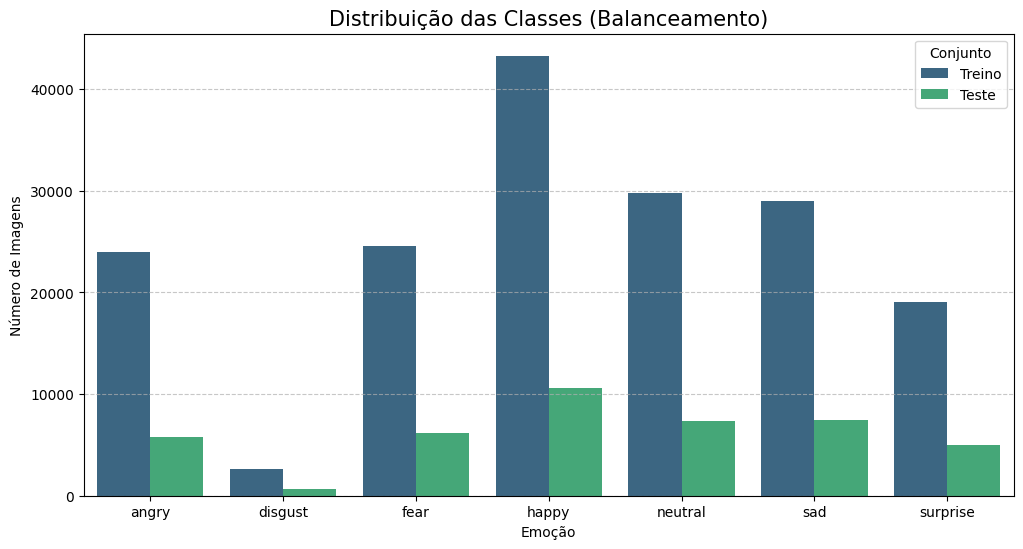

,Emoção,Treino,Teste
0,angry,23970,5748
1,disgust,2616,666
2,fear,24582,6144
3,happy,43290,10644
4,neutral,29790,7398
5,sad,28980,7482
6,surprise,19026,4986


--- Analisando estatísticas de pixels (Amostra: 10000 imgs) ---
Média de intensidade de pixel: 127.88 (Esperado ~127.5)
Desvio Padrão dos pixels: 66.56
Imagens com baixo contraste (potenciais outliers): 2


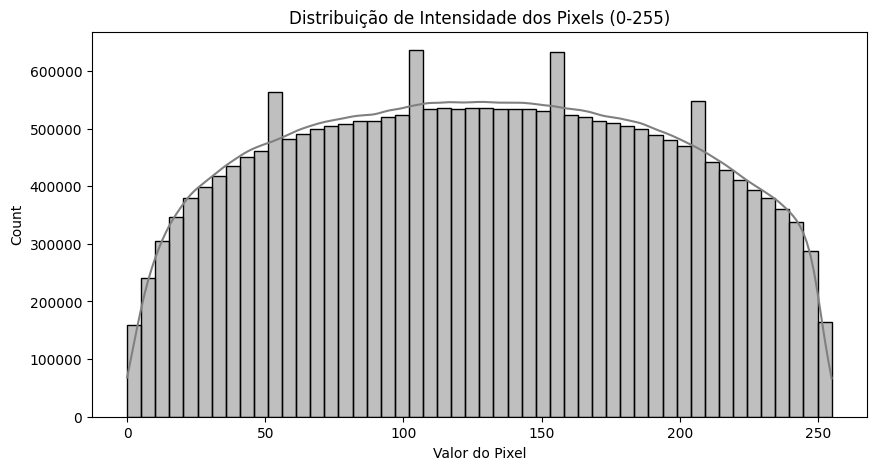

In [6]:
df_distribuicao = analisar_distribuicao_classes(train_dir, test_dir)

display(df_distribuicao)

analisar_pixels_amostra(train_dir)

### Resultados da Análise Estatística

A análise exploratória dos dados revelou características cruciais que impactarão a estratégia de treinamento, especialmente no que tange ao desbalanceamento das classes.

#### 3.1. Balanceamento das Classes (Variável de Saída)
Observa-se um desbalanceamento na distribuição das emoções. A classe *Happy* (Felicidade) é a predominante, enquanto a classe *Disgust* (Nojo) possui uma representatividade baixa em comparação às demais.

| Emoção | Treino (Qtd) | Teste (Qtd) | Proporção (Treino) |
| :--- | :---: | :---: | :---: |
| Happy | 43.290 | 10.644 | ~25.1% |
| Neutral | 29.790 | 7.398 | ~17.3% |
| Sad | 28.980 | 7.482 | ~16.8% |
| Fear | 24.582 | 6.144 | ~14.3% |
| Angry | 23.970 | 5.748 | ~13.9% |
| Surprise | 19.026 | 4.986 | ~11.0% |
| Disgust | 2.616 | 666 | ~1.5% |

Devido ao desbalanceamento o modelo terá uma tendência natural a superestimar "Felicidade" e ignorar "Nojo". Será útil utilizar técnicas de compensação, como o cálculo de Pesos de Classe (`class_weights`) na função de perda durante o treinamento, para penalizar mais fortemente os erros nas classes minoritárias.

#### 3.2. Análise dos Pixels (Variáveis de Entrada)
A análise de uma amostra aleatória e o histograma de intensidades indicam que as imagens possuem boa qualidade estatística para o aprendizado:

* Média de Intensidade: $127.88$. Este valor está muito próximo do centro ideal ($127.5$ para escala 0-255), indicando que a base não sofre de problemas de subexposição (muito escura) ou superexposição (muito clara).
* Desvio Padrão: $66.51$. O desvio padrão alto confirma que as imagens possuem bom contraste e variação de texturas, essenciais para a detecção de bordas pelas camadas convolucionais.
* Distribuição: O histograma apresenta uma distribuição ampla cobrindo todo o espectro (0 a 255), sem picos anômalos nas extremidades que sugerissem perda de dados.
* Outliers: A taxa de imagens com baixo contraste (potencialmente defeituosas) foi insignificante (< 0.1% na amostra), não exigindo filtragem agressiva.

Conclusão: As imagens da base de dados parecem boas para o treinamento, porém a base de dados não é balanceada.

---

## 4. Pré-processamento e Normalização

Com base na análise dos dados brutos, foram definidas as seguintes técnicas de pré-processamento, essenciais para a convergência do modelo e para a mitigação do desbalanceamento:

### 4.1. Normalização (Rescaling)
As redes neurais operam de forma mais eficiente com valores pequenos. Os pixels originais variam de 0 a 255.
* Técnica: Divisão escalar por 255.
* Resultado: Todos os valores de entrada ($X$) estarão contidos no intervalo $[0, 1]$. Isso evita instabilidade nos gradientes e acelera o treinamento.

### 4.2. Data Augmentation (Aumento de Dados)
Dada a natureza complexa das expressões faciais e o risco de *overfitting*, aplicaremos transformações geométricas aleatórias nas imagens de treinamento. Isso simula variações de cenário que a câmera pode captar no mundo real.
* Transformações aplicadas:
    * Rotação: Leves inclinações da cabeça.
    * Zoom: Aproximação ou afastamento simulado.
    * Espelhamento Horizontal (Flip): Uma expressão é válida tanto para o lado esquerdo quanto direito.
    * Translação (Shift): Deslocamentos verticais e horizontais leves.

### 4.3. Tratamento da Variável Alvo
Os rótulos das emoções serão convertidos para o formato One-Hot Encoding (vetores binários).
* Exemplo: `Happy` (Classe 3) $\to$ `[0, 0, 0, 1, 0, 0, 0]`.

Isso será feito em conjunto com o item 8 mais adiante.

---

## 5. Definição das Arquiteturas (Experimento Comparativo)

Para atender ao requisito de ajuste de parâmetros e seleção da melhor topologia, propõe-se a avaliação de três arquiteturas de Redes Neurais Convolucionais distintas. O objetivo é comparar o compromisso entre complexidade computacional e acurácia.

### As Arquiteturas Propostas

1.  Modelo 1 (Light): Arquitetura simplificada com apenas 3 blocos convolucionais e menor número de filtros (32 $\to$ 64 $\to$ 128). O objetivo é verificar se um modelo mais leve consegue generalizar bem, focando em velocidade.
2.  Modelo 2 (Base - VGG Style): Arquitetura baseada na VGGNet, com 4 blocos convolucionais mais profundos (64 $\to$ 128 $\to$ 256 $\to$ 512) e ativação ReLU. Este serve como nosso *baseline* (referência).
3.  Modelo 3 (Heavy - ELU + Dense): Uma variação do modelo base com maior complexidade. Substitui a ativação ReLU por ELU (Exponential Linear Unit) para tratar neurônios inativos e adiciona camadas densas extras no classificador final, aumentando a capacidade de abstração.

---

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_model_1_light(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_model_2_base(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_model_3_heavy(input_shape, num_classes):
    """Modelo Heavy: Ativação ELU e Camadas Densas Extras."""
    model = Sequential([
        # Usando 'elu' em vez de 'relu'
        Conv2D(64, (3, 3), padding='same', activation='elu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding='same', activation='elu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(256, (3, 3), padding='same', activation='elu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(512, (3, 3), padding='same', activation='elu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(512, activation='elu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='elu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    return model

# 6. Extração de Características e Redução de Dimensionalidade

Nesta abordagem baseada em Deep Learning, a extração de características e a redução de dimensionalidade são processos intrínsecos à arquitetura da CNN, dispensando algoritmos manuais externos (como PCA ou descritores HOG).

### 6.1. Extração de Características (Feature Extraction)
A rede neural realiza a extração automática de características hierárquicas através das camadas `Conv2D`.
* Camadas Iniciais: Detectam características simples (bordas, contrastes).
* Camadas Profundas: Combinam essas características simples para formar padrões complexos (olhos, sorrisos, formatos de rosto).

### 6.2. Redução de Dimensão (Dimensionality Reduction)
A redução da dimensionalidade espacial dos dados é realizada pelas camadas de Pooling (`MaxPooling2D`). Isso é fundamental para tornar o modelo computacionalmente viável e focar na presença da característica, não em sua posição exata.

Fluxo de Redução na Arquitetura Proposta:
A imagem original de entrada possui dimensão $48 \times 48$. A cada bloco de processamento, a dimensão espacial é reduzida pela metade, enquanto a "profundidade" (número de características aprendidas) aumenta:

1.  Entrada: $48 \times 48$ pixels.
2.  Após 1º Pooling: $24 \times 24$.
3.  Após 2º Pooling: $12 \times 12$.
4.  Após 3º Pooling: $6 \times 6$.
5.  Após 4º Pooling: $3 \times 3$.

Ao final, a imagem original de 2.304 pixels é condensada em mapas de características abstratas de $3 \times 3$, contendo apenas a "essência" visual necessária para a classificação.

---

# 7. Seleção de Variáveis de Entrada

Diferente de problemas tabulares onde se selecionam colunas específicas, em visão computacional a seleção de variáveis consiste em isolar os pixels que contêm a informação relevante (o rosto) e descartar ruídos (fundo, roupas, iluminação de cor).

### 7.1. Seleção Espacial (Region of Interest - ROI)
A seleção de variáveis é realizada através da detecção facial.
* No Treinamento: A base de dados utilizada contém imagens pré-processadas onde a "variável de entrada" é estritamente a face humana centralizada, excluindo o ambiente ao redor.
* Na Aplicação Real (Webcam): O algoritmo *HaarCascade* atua como um seletor dinâmico de variáveis, recortando apenas a região da face antes de enviar os dados para a rede neural. Isso garante que o modelo não seja contaminado por variáveis irrelevantes (background).

### 7.2. Seleção de Espectro (Grayscale)
Optou-se por utilizar imagens em escala de cinza (1 canal) em vez de RGB (3 canais).
* Justificativa: Expressões faciais são definidas por deformações geométricas (formato da boca, abertura dos olhos, rugas), e não por cores. A eliminação dos canais de cor reduz a dimensionalidade da entrada em 66% (de 3 canais para 1) sem perda de informação relevante para a classificação da emoção, tornando o processamento mais eficiente.

---

## 8. Partição e Representatividade dos Dados

### 8.1. Representatividade
A base de dados utilizada deriva da FER2013, construída através da busca de imagens no Google com palavras-chave de emoções. Isso garante uma base genérica e "in-the-wild" (condições não controladas), o que é excelente para generalização em aplicações reais, pois contém variações de iluminação, oclusão parcial e poses variadas, diferente de bases de laboratório (como a CK+).

### 8.2. Balanceamento
Conforme apresentado no Item 3, a base original é desbalanceada. Para manter a representatividade estatística durante a partição, utilizamos amostragem mantendo a proporção original das classes em todos os subconjuntos. O desbalanceamento será tratado via *Class Weights* na função de perda.

### 8.3. Partição dos Conjuntos (Train / Validation / Test)

1.  Treinamento: 90% do conjunto de treinamento (155030  imagens).
2.  Validação: 10% do conjunto de treinamento (17224 imagens).

In [8]:
batch_size = 64

train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

test_datagen_final = ImageDataGenerator(rescale=1./255)

print("--- Construindo Conjuntos de Dados ---")

train_generator = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation', 
    shuffle=False        
)

test_generator = test_datagen_final.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"\nResumo da Partição:")
print(f"Treino: {train_generator.samples} imagens")
print(f"Validação: {validation_generator.samples} imagens")
print(f"Teste: {test_generator.samples} imagens")

--- Construindo Conjuntos de Dados ---
Found 155030 images belonging to 7 classes.
Found 17224 images belonging to 7 classes.
Found 43068 images belonging to 7 classes.

Resumo da Partição:
Treino: 155030 imagens
Validação: 17224 imagens
Teste: 43068 imagens


In [9]:
from sklearn.utils import class_weight

# Extraindo os índices das classes do gerador de treino
# O gerador tem um atributo .classes que retorna o array de índices
y_train_indices = train_generator.classes

# Calculando pesos para equilibrar as classes
# 'balanced': calcula pesos inversamente proporcionais à frequência da classe
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

# Convertendo para dicionário (formato exigido pelo Keras)
class_weights_dict = dict(enumerate(class_weights_array))

print("Pesos calculados para cada classe:")
for idx, weight in class_weights_dict.items():
    # Pega o nome da classe baseado no índice
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(idx)]
    print(f"{class_name}: {weight:.4f}")

Pesos calculados para cada classe:
angry: 1.0266
disgust: 9.4043
fear: 1.0010
happy: 0.5684
neutral: 0.8260
sad: 0.8491
surprise: 1.2933


## 9. Ajuste de Parâmetros e Treinamento Comparativo

Nesta etapa, realizamos o treinamento dos três modelos propostos utilizando as mesmas configurações de base para garantir uma comparação justa.

### 9.1. Configuração dos Hiperparâmetros
Foram definidos os seguintes parâmetros globais:

* Otimizador: `Adam` (Learning Rate inicial de `0.001`).
* Função de Perda: `Categorical Crossentropy` com aplicação de Class Weights para mitigar o desbalanceamento.
* Épocas: Até `40` épocas por modelo.

### 9.2. Callbacks (Controle Dinâmico)
Para cada treinamento, utilizamos:
1.  ModelCheckpoint: Salva individualmente o melhor peso de cada arquitetura (`best_Modelo_1.h5`, etc.) baseado na menor `val_loss`.
2.  EarlyStopping: Interrompe se não houver melhora após 10 épocas.
3.  ReduceLROnPlateau: Reduz a taxa de aprendizado pela metade se o modelo estagnar.

---

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# ==========================================
# Loop de Treinamento Comparativo
# ==========================================

model_functions = {
    'Modelo_1_Light': create_model_1_light,
    'Modelo_2_Base': create_model_2_base,
    'Modelo_3_Heavy': create_model_3_heavy
}

history_dict = {}
input_shape = (48, 48, 1)
num_classes = 7

# Defina quantas épocas quer testar (sugestão: 40 a 60)
EPOCHS = 100 

for name, model_func in model_functions.items():
    print(f"\n{'='*40}")
    print(f"Treinando: {name}")
    print(f"{'='*40}")
    
    # 1. Cria o modelo
    model = model_func(input_shape, num_classes)
    
    # 2. Compila
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 3. Callbacks específicos para cada modelo (salva arquivos diferentes)
    checkpoint = ModelCheckpoint(
        filepath=f'best_{name}.h5', 
        monitor='val_loss', 
        save_best_only=True, 
        mode='min', 
        verbose=1
    )
    # Early stopping compartilhado
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    
    # 4. Treina
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        class_weight=class_weights_dict, # Nossos pesos calculados anteriormente
        callbacks=[checkpoint, early_stop, reduce_lr],
        verbose=1 
    )
    
    # Salva o histórico para compararmos depois
    history_dict[name] = history
    print(f"--- Fim do treino de {name} ---")


Treinando: Modelo_1_Light


c:\Users\UlissesLS\OneDrive - ga.ita.br\ITA\8º Semestre\2. ET-287 - Processamento de Sinais usando Redes Neurais\Projetos\Projeto Final\et287\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\UlissesLS\OneDrive - ga.ita.br\ITA\8º Semestre\2. ET-287 - Processamento de Sinais usando Redes Neurais\Projetos\Projeto Final\et287\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.1815 - loss: 2.1523
Epoch 1: val_loss improved from inf to 1.74585, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 369s 151ms/step - accuracy: 0.1815 - loss: 2.1523 - val_accuracy: 0.3059 - val_loss: 1.7459 - learning_rate: 0.0010
Epoch 2/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:23 109ms/step - accuracy: 0.3438 - loss: 1.7231

c:\Users\UlissesLS\OneDrive - ga.ita.br\ITA\8º Semestre\2. ET-287 - Processamento de Sinais usando Redes Neurais\Projetos\Projeto Final\et287\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.74585 to 1.74463, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.3438 - loss: 1.7231 - val_accuracy: 0.3152 - val_loss: 1.7446 - learning_rate: 0.0010
Epoch 3/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2958 - loss: 1.7667
Epoch 3: val_loss improved from 1.74463 to 1.61547, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 341s 141ms/step - accuracy: 0.2958 - loss: 1.7667 - val_accuracy: 0.3751 - val_loss: 1.6155 - learning_rate: 0.0010
Epoch 4/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:23 109ms/step - accuracy: 0.2812 - loss: 1.7405
Epoch 4: val_loss improved from 1.61547 to 1.60346, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2812 - loss: 1.7405 - val_accuracy: 0.3742 - val_loss: 1.6035 - learning_rate: 0.0010
Epoch 5/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3454 - loss: 1.6698
Epoch 5: val_loss improved from 1.60346 to 1.56874, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 322s 133ms/step - accuracy: 0.3454 - loss: 1.6698 - val_accuracy: 0.4302 - val_loss: 1.5687 - learning_rate: 0.0010
Epoch 6/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:31 112ms/step - accuracy: 0.2500 - loss: 2.2469
Epoch 6: val_loss improved from 1.56874 to 1.52750, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2500 - loss: 2.2469 - val_accuracy: 0.4319 - val_loss: 1.5275 - learning_rate: 0.0010
Epoch 7/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3646 - loss: 1.6259
Epoch 7: val_loss improved from 1.52750 to 1.48220, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 328s 136ms/step - accuracy: 0.3646 - loss: 1.6259 - val_accuracy: 0.4441 - val_loss: 1.4822 - learning_rate: 0.0010
Epoch 8/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:57 98ms/step - accuracy: 0.3750 - loss: 1.6037
Epoch 8: val_loss did not improve from 1.48220
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3750 - loss: 1.6037 - val_accuracy: 0.4492 - val_loss: 1.4935 - learning_rate: 0.0010
Epoch 9/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3809 - loss: 1.5809
Epoch 9: val_loss improved from 1.48220 to 1.48181, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 317s 131ms/step - accuracy: 0.3809 - loss: 1.5809 - val_accuracy: 0.4402 - val_loss: 1.4818 - learning_rate: 0.0010
Epoch 10/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:47 94ms/step - accuracy: 0.4375 - loss: 1.3141
Epoch 10: val_loss improved from 1.48181 to 1.47906, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4375 - loss: 1.3141 - val_accuracy: 0.4409 - val_loss: 1.4791 - learning_rate: 0.0010
Epoch 11/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3872 - loss: 1.5663
Epoch 11: val_loss did not improve from 1.47906
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 309s 128ms/step - accuracy: 0.3872 - loss: 1.5663 - val_accuracy: 0.4251 - val_loss: 1.5083 - learning_rate: 0.0010
Epoch 12/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:02 100ms/step - accuracy: 0.2969 - loss: 1.3923
Epoch 12: val_loss did not improve from 1.47906
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2969 - loss: 1.3923 - val_accuracy: 0.4238 - val_loss: 1.5067 - learning_rate: 0.0010
Epoch 13/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3982 - loss: 1.5455
Epoch 13: val_loss improved from 1.47906 to 1.46394, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 321s 133ms/step - accuracy: 0.3982 - loss: 1.5455 - val_accuracy: 0.4349 - val_loss: 1.4639 - learning_rate: 0.0010
Epoch 14/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:03 101ms/step - accuracy: 0.3906 - loss: 1.5129
Epoch 14: val_loss improved from 1.46394 to 1.46281, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3906 - loss: 1.5129 - val_accuracy: 0.4331 - val_loss: 1.4628 - learning_rate: 0.0010
Epoch 15/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4048 - loss: 1.5153
Epoch 15: val_loss improved from 1.46281 to 1.37504, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 320s 132ms/step - accuracy: 0.4048 - loss: 1.5153 - val_accuracy: 0.4762 - val_loss: 1.3750 - learning_rate: 0.0010
Epoch 16/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:57 98ms/step - accuracy: 0.4219 - loss: 1.3529
Epoch 16: val_loss improved from 1.37504 to 1.37078, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4219 - loss: 1.3529 - val_accuracy: 0.4767 - val_loss: 1.3708 - learning_rate: 0.0010
Epoch 17/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4129 - loss: 1.5031
Epoch 17: val_loss did not improve from 1.37078
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 323s 134ms/step - accuracy: 0.4129 - loss: 1.5030 - val_accuracy: 0.4571 - val_loss: 1.4002 - learning_rate: 0.0010
Epoch 18/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:06 102ms/step - accuracy: 0.3125 - loss: 1.7300
Epoch 18: val_loss did not improve from 1.37078
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3125 - loss: 1.7300 - val_accuracy: 0.4572 - val_loss: 1.4015 - learning_rate: 0.0010
Epoch 19/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4168 - loss: 1.4876
Epoch 19: val_loss improved from 1.37078 to 1.33636, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 333s 138ms/step - accuracy: 0.4168 - loss: 1.4876 - val_accuracy: 0.4889 - val_loss: 1.3364 - learning_rate: 0.0010
Epoch 20/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:56 98ms/step - accuracy: 0.4531 - loss: 1.3146
Epoch 20: val_loss improved from 1.33636 to 1.33309, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4531 - loss: 1.3146 - val_accuracy: 0.4916 - val_loss: 1.3331 - learning_rate: 0.0010
Epoch 21/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4227 - loss: 1.4811
Epoch 21: val_loss did not improve from 1.33309
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 323s 133ms/step - accuracy: 0.4227 - loss: 1.4811 - val_accuracy: 0.4855 - val_loss: 1.3521 - learning_rate: 0.0010
Epoch 22/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:08 103ms/step - accuracy: 0.3281 - loss: 2.0209
Epoch 22: val_loss did not improve from 1.33309
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3281 - loss: 2.0209 - val_accuracy: 0.4825 - val_loss: 1.3568 - learning_rate: 0.0010
Epoch 23/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4267 - loss: 1.4589
Epoch 23: val_loss improved from 1.33309 to 1.28890, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 322s 133ms/step - accuracy: 0.4267 - loss: 1.4589 - val_accuracy: 0.5094 - val_loss: 1.2889 - learning_rate: 0.0010
Epoch 24/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:56 98ms/step - accuracy: 0.5156 - loss: 1.8653
Epoch 24: val_loss did not improve from 1.28890
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5156 - loss: 1.8653 - val_accuracy: 0.5094 - val_loss: 1.2921 - learning_rate: 0.0010
Epoch 25/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4307 - loss: 1.4458
Epoch 25: val_loss did not improve from 1.28890
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 320s 132ms/step - accuracy: 0.4307 - loss: 1.4458 - val_accuracy: 0.4965 - val_loss: 1.3784 - learning_rate: 0.0010
Epoch 26/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:53 96ms/step - accuracy: 0.4531 - loss: 1.2881
Epoch 26: val_loss did not improve from 1.28890
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4531 - loss: 1.2881 - val_accuracy: 0.4945 - val_loss: 1.3650 - learning_rate: 0.0

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 326s 134ms/step - accuracy: 0.4441 - loss: 1.4091 - val_accuracy: 0.5155 - val_loss: 1.2760 - learning_rate: 5.0000e-04
Epoch 30/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:48 94ms/step - accuracy: 0.3438 - loss: 1.4329
Epoch 30: val_loss did not improve from 1.27599
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3438 - loss: 1.4329 - val_accuracy: 0.5130 - val_loss: 1.2773 - learning_rate: 5.0000e-04
Epoch 31/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4501 - loss: 1.3956
Epoch 31: val_loss improved from 1.27599 to 1.26877, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 327s 135ms/step - accuracy: 0.4501 - loss: 1.3956 - val_accuracy: 0.5166 - val_loss: 1.2688 - learning_rate: 5.0000e-04
Epoch 32/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:00 99ms/step - accuracy: 0.5156 - loss: 1.1973
Epoch 32: val_loss improved from 1.26877 to 1.26666, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5156 - loss: 1.1973 - val_accuracy: 0.5163 - val_loss: 1.2667 - learning_rate: 5.0000e-04
Epoch 33/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4531 - loss: 1.3920
Epoch 33: val_loss improved from 1.26666 to 1.24484, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 323s 133ms/step - accuracy: 0.4531 - loss: 1.3920 - val_accuracy: 0.5257 - val_loss: 1.2448 - learning_rate: 5.0000e-04
Epoch 34/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:55 97ms/step - accuracy: 0.3906 - loss: 1.4603
Epoch 34: val_loss improved from 1.24484 to 1.24202, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3906 - loss: 1.4603 - val_accuracy: 0.5265 - val_loss: 1.2420 - learning_rate: 5.0000e-04
Epoch 35/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4570 - loss: 1.3784
Epoch 35: val_loss did not improve from 1.24202
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 322s 133ms/step - accuracy: 0.4570 - loss: 1.3784 - val_accuracy: 0.5066 - val_loss: 1.2764 - learning_rate: 5.0000e-04
Epoch 36/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:56 98ms/step - accuracy: 0.5312 - loss: 1.1317
Epoch 36: val_loss did not improve from 1.24202
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5312 - loss: 1.1317 - val_accuracy: 0.5101 - val_loss: 1.2773 - learning_rate: 5.0000e-04
Epoch 37/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4552 - loss: 1.3846
Epoch 37: val_loss did not improve from 1.24202
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 322s 133ms/step - accuracy: 0.4552 - loss: 1.3846 - val_accuracy: 0.5112 - val_loss: 1.2736 - learnin

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 322s 133ms/step - accuracy: 0.4573 - loss: 1.3644 - val_accuracy: 0.5386 - val_loss: 1.2174 - learning_rate: 2.5000e-04
Epoch 40/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:51 95ms/step - accuracy: 0.3906 - loss: 1.3477
Epoch 40: val_loss did not improve from 1.21742
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3906 - loss: 1.3477 - val_accuracy: 0.5357 - val_loss: 1.2191 - learning_rate: 2.5000e-04
Epoch 41/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4628 - loss: 1.3525
Epoch 41: val_loss did not improve from 1.21742
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 322s 133ms/step - accuracy: 0.4628 - loss: 1.3525 - val_accuracy: 0.5116 - val_loss: 1.2676 - learning_rate: 2.5000e-04
Epoch 42/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:43 92ms/step - accuracy: 0.4062 - loss: 1.9238
Epoch 42: val_loss did not improve from 1.21742
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4062 - loss: 1.9238 - val_accuracy: 0.5145 - val_loss: 1.2710 - learni

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5000 - loss: 1.2025 - val_accuracy: 0.5352 - val_loss: 1.2164 - learning_rate: 1.2500e-04
Epoch 47/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4652 - loss: 1.3468
Epoch 47: val_loss improved from 1.21643 to 1.20764, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 325s 134ms/step - accuracy: 0.4652 - loss: 1.3468 - val_accuracy: 0.5409 - val_loss: 1.2076 - learning_rate: 1.2500e-04
Epoch 48/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:49 95ms/step - accuracy: 0.4062 - loss: 1.3802
Epoch 48: val_loss improved from 1.20764 to 1.20749, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4062 - loss: 1.3802 - val_accuracy: 0.5404 - val_loss: 1.2075 - learning_rate: 1.2500e-04
Epoch 49/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4638 - loss: 1.3522
Epoch 49: val_loss did not improve from 1.20749
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 326s 135ms/step - accuracy: 0.4638 - loss: 1.3522 - val_accuracy: 0.5306 - val_loss: 1.2291 - learning_rate: 1.2500e-04
Epoch 50/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:49 95ms/step - accuracy: 0.4688 - loss: 1.2240
Epoch 50: val_loss did not improve from 1.20749
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4688 - loss: 1.2240 - val_accuracy: 0.5286 - val_loss: 1.2284 - learning_rate: 1.2500e-04
Epoch 51/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.4657 - loss: 1.3537
Epoch 51: val_loss did not improve from 1.20749
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 314s 130ms/step - accuracy: 0.4657 - loss: 1.3537 - val_accuracy: 0.5396 - val_loss: 1.2121 - learnin

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 325s 134ms/step - accuracy: 0.4658 - loss: 1.3504 - val_accuracy: 0.5467 - val_loss: 1.1913 - learning_rate: 6.2500e-05
Epoch 54/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:06 102ms/step - accuracy: 0.6094 - loss: 1.0949
Epoch 54: val_loss did not improve from 1.19132
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.6094 - loss: 1.0949 - val_accuracy: 0.5459 - val_loss: 1.1948 - learning_rate: 6.2500e-05
Epoch 55/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4689 - loss: 1.3317
Epoch 55: val_loss did not improve from 1.19132
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 323s 133ms/step - accuracy: 0.4689 - loss: 1.3317 - val_accuracy: 0.5477 - val_loss: 1.1931 - learning_rate: 6.2500e-05
Epoch 56/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:02 100ms/step - accuracy: 0.5625 - loss: 1.1091
Epoch 56: val_loss improved from 1.19132 to 1.18821, saving model to best_Modelo_1_Light.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5625 - loss: 1.1091 - val_accuracy: 0.5469 - val_loss: 1.1882 - learning_rate: 6.2500e-05
Epoch 57/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4703 - loss: 1.3299
Epoch 57: val_loss did not improve from 1.18821
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 321s 133ms/step - accuracy: 0.4703 - loss: 1.3299 - val_accuracy: 0.5429 - val_loss: 1.2021 - learning_rate: 6.2500e-05
Epoch 58/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:21 108ms/step - accuracy: 0.5469 - loss: 1.2159
Epoch 58: val_loss did not improve from 1.18821
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5469 - loss: 1.2159 - val_accuracy: 0.5484 - val_loss: 1.1946 - learning_rate: 6.2500e-05
Epoch 59/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4694 - loss: 1.3401
Epoch 59: val_loss did not improve from 1.18821
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 322s 133ms/step - accuracy: 0.4694 - loss: 1.3401 - val_accuracy: 0.5422 - val_loss: 1.1954 - learni

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 321s 133ms/step - accuracy: 0.4710 - loss: 1.3325 - val_accuracy: 0.5479 - val_loss: 1.1873 - learning_rate: 3.1250e-05
Epoch 62/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 3:57 98ms/step - accuracy: 0.5156 - loss: 1.2337
Epoch 62: val_loss did not improve from 1.18726
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5156 - loss: 1.2337 - val_accuracy: 0.5464 - val_loss: 1.1924 - learning_rate: 3.1250e-05
Epoch 63/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4690 - loss: 1.3328
Epoch 63: val_loss did not improve from 1.18726
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 353s 146ms/step - accuracy: 0.4690 - loss: 1.3328 - val_accuracy: 0.5446 - val_loss: 1.1901 - learning_rate: 3.1250e-05
Epoch 64/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:36 114ms/step - accuracy: 0.5312 - loss: 1.1553
Epoch 64: val_loss did not improve from 1.18726
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.5312 - loss: 1.1553 - val_accuracy: 0.5463 - val_loss: 1.1913 - learn

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 356s 147ms/step - accuracy: 0.4724 - loss: 1.3344 - val_accuracy: 0.5492 - val_loss: 1.1871 - learning_rate: 1.5625e-05
Epoch 68/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 6:09 153ms/step - accuracy: 0.5469 - loss: 1.0769
Epoch 68: val_loss did not improve from 1.18712
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5469 - loss: 1.0769 - val_accuracy: 0.5477 - val_loss: 1.1881 - learning_rate: 1.5625e-05
Epoch 69/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4694 - loss: 1.3376
Epoch 69: val_loss did not improve from 1.18712
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 402s 166ms/step - accuracy: 0.4694 - loss: 1.3376 - val_accuracy: 0.5468 - val_loss: 1.1887 - learning_rate: 1.5625e-05
Epoch 70/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 4:34 113ms/step - accuracy: 0.6094 - loss: 1.1834
Epoch 70: val_loss did not improve from 1.18712
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.6094 - loss: 1.1834 - val_accuracy: 0.5471 - val_loss: 1.1927 - lear

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 756s 311ms/step - accuracy: 0.1875 - loss: 2.1928 - val_accuracy: 0.1585 - val_loss: 2.5326 - learning_rate: 0.0010
Epoch 2/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 11:42 290ms/step - accuracy: 0.2500 - loss: 1.6579
Epoch 2: val_loss improved from 2.53259 to 2.52469, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.2500 - loss: 1.6579 - val_accuracy: 0.1602 - val_loss: 2.5247 - learning_rate: 0.0010
Epoch 3/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3282 - loss: 1.7187
Epoch 3: val_loss improved from 2.52469 to 1.55314, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 747s 309ms/step - accuracy: 0.3282 - loss: 1.7186 - val_accuracy: 0.3972 - val_loss: 1.5531 - learning_rate: 0.0010
Epoch 4/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:25 308ms/step - accuracy: 0.4219 - loss: 1.4587
Epoch 4: val_loss did not improve from 1.55314
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.4219 - loss: 1.4587 - val_accuracy: 0.3829 - val_loss: 1.5823 - learning_rate: 0.0010
Epoch 5/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.3843 - loss: 1.5803
Epoch 5: val_loss improved from 1.55314 to 1.41510, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 1007s 416ms/step - accuracy: 0.3843 - loss: 1.5803 - val_accuracy: 0.4548 - val_loss: 1.4151 - learning_rate: 0.0010
Epoch 6/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:35 312ms/step - accuracy: 0.3906 - loss: 1.9272
Epoch 6: val_loss improved from 1.41510 to 1.40192, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.3906 - loss: 1.9272 - val_accuracy: 0.4646 - val_loss: 1.4019 - learning_rate: 0.0010
Epoch 7/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.4117 - loss: 1.5099
Epoch 7: val_loss improved from 1.40192 to 1.34045, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 943s 389ms/step - accuracy: 0.4117 - loss: 1.5099 - val_accuracy: 0.4859 - val_loss: 1.3405 - learning_rate: 0.0010
Epoch 8/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:18 305ms/step - accuracy: 0.4219 - loss: 1.4168
Epoch 8: val_loss did not improve from 1.34045
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4219 - loss: 1.4168 - val_accuracy: 0.4806 - val_loss: 1.3459 - learning_rate: 0.0010
Epoch 9/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.4349 - loss: 1.4532
Epoch 9: val_loss improved from 1.34045 to 1.26139, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 770s 318ms/step - accuracy: 0.4349 - loss: 1.4532 - val_accuracy: 0.5170 - val_loss: 1.2614 - learning_rate: 0.0010
Epoch 10/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:40 314ms/step - accuracy: 0.3906 - loss: 1.7869
Epoch 10: val_loss improved from 1.26139 to 1.25628, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.3906 - loss: 1.7869 - val_accuracy: 0.5195 - val_loss: 1.2563 - learning_rate: 0.0010
Epoch 11/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.4471 - loss: 1.4230
Epoch 11: val_loss did not improve from 1.25628
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 791s 326ms/step - accuracy: 0.4471 - loss: 1.4230 - val_accuracy: 0.5124 - val_loss: 1.2772 - learning_rate: 0.0010
Epoch 12/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:01 298ms/step - accuracy: 0.4531 - loss: 1.3573
Epoch 12: val_loss did not improve from 1.25628
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.4531 - loss: 1.3573 - val_accuracy: 0.5110 - val_loss: 1.2774 - learning_rate: 0.0010
Epoch 13/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.4529 - loss: 1.3896
Epoch 13: val_loss improved from 1.25628 to 1.25090, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 819s 338ms/step - accuracy: 0.4529 - loss: 1.3896 - val_accuracy: 0.5320 - val_loss: 1.2509 - learning_rate: 0.0010
Epoch 14/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 17:00 422ms/step - accuracy: 0.5000 - loss: 1.1112
Epoch 14: val_loss did not improve from 1.25090
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.5000 - loss: 1.1112 - val_accuracy: 0.5314 - val_loss: 1.2525 - learning_rate: 0.0010
Epoch 15/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4613 - loss: 1.3716
Epoch 15: val_loss did not improve from 1.25090
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 849s 350ms/step - accuracy: 0.4613 - loss: 1.3716 - val_accuracy: 0.5079 - val_loss: 1.3077 - learning_rate: 0.0010
Epoch 16/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:20 306ms/step - accuracy: 0.4844 - loss: 1.2364
Epoch 16: val_loss did not improve from 1.25090
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.4844 - loss: 1.2364 - val_accuracy: 0.5068 - val_loss: 1.3067 - learning_rat

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 776s 320ms/step - accuracy: 0.4807 - loss: 1.3205 - val_accuracy: 0.5550 - val_loss: 1.1815 - learning_rate: 5.0000e-04
Epoch 20/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 11:51 294ms/step - accuracy: 0.4844 - loss: 1.1998
Epoch 20: val_loss did not improve from 1.18155
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4844 - loss: 1.1998 - val_accuracy: 0.5530 - val_loss: 1.1831 - learning_rate: 5.0000e-04
Epoch 21/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.4926 - loss: 1.2787
Epoch 21: val_loss did not improve from 1.18155
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 662s 273ms/step - accuracy: 0.4926 - loss: 1.2787 - val_accuracy: 0.5520 - val_loss: 1.1947 - learning_rate: 5.0000e-04
Epoch 22/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 10:34 262ms/step - accuracy: 0.5000 - loss: 1.1776
Epoch 22: val_loss did not improve from 1.18155
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.5000 - loss: 1.1776 - val_accuracy: 0.5522 - val_loss: 1.1937 - le

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 654s 270ms/step - accuracy: 0.4973 - loss: 1.2680 - val_accuracy: 0.5666 - val_loss: 1.1368 - learning_rate: 5.0000e-04
Epoch 24/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 10:39 264ms/step - accuracy: 0.4688 - loss: 1.1714
Epoch 24: val_loss did not improve from 1.13676
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4688 - loss: 1.1714 - val_accuracy: 0.5649 - val_loss: 1.1448 - learning_rate: 5.0000e-04
Epoch 25/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5046 - loss: 1.2400
Epoch 25: val_loss did not improve from 1.13676
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 714s 295ms/step - accuracy: 0.5046 - loss: 1.2400 - val_accuracy: 0.5715 - val_loss: 1.1428 - learning_rate: 5.0000e-04
Epoch 26/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:11 302ms/step - accuracy: 0.4844 - loss: 1.1745
Epoch 26: val_loss did not improve from 1.13676
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.4844 - loss: 1.1745 - val_accuracy: 0.5659 - val_loss: 1.1477 - l

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 772s 319ms/step - accuracy: 0.5085 - loss: 1.2294 - val_accuracy: 0.5785 - val_loss: 1.1168 - learning_rate: 5.0000e-04
Epoch 28/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:35 312ms/step - accuracy: 0.5000 - loss: 1.1343
Epoch 28: val_loss improved from 1.11675 to 1.11563, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.5000 - loss: 1.1343 - val_accuracy: 0.5776 - val_loss: 1.1156 - learning_rate: 5.0000e-04
Epoch 29/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.5118 - loss: 1.2235
Epoch 29: val_loss improved from 1.11563 to 1.09626, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 778s 321ms/step - accuracy: 0.5118 - loss: 1.2235 - val_accuracy: 0.5816 - val_loss: 1.0963 - learning_rate: 5.0000e-04
Epoch 30/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:45 316ms/step - accuracy: 0.5156 - loss: 1.2663
Epoch 30: val_loss improved from 1.09626 to 1.09099, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.5156 - loss: 1.2663 - val_accuracy: 0.5861 - val_loss: 1.0910 - learning_rate: 5.0000e-04
Epoch 31/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5154 - loss: 1.2148
Epoch 31: val_loss did not improve from 1.09099
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 747s 308ms/step - accuracy: 0.5154 - loss: 1.2148 - val_accuracy: 0.5847 - val_loss: 1.0961 - learning_rate: 5.0000e-04
Epoch 32/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 11:25 283ms/step - accuracy: 0.4844 - loss: 1.2134
Epoch 32: val_loss did not improve from 1.09099
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4844 - loss: 1.2134 - val_accuracy: 0.5877 - val_loss: 1.0978 - learning_rate: 5.0000e-04
Epoch 33/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5203 - loss: 1.2009
Epoch 33: val_loss did not improve from 1.09099
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 770s 318ms/step - accuracy: 0.5203 - loss: 1.2009 - val_accuracy: 0.5736 - val_loss: 1.1284 - learn

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 763s 315ms/step - accuracy: 0.5237 - loss: 1.1826 - val_accuracy: 0.5941 - val_loss: 1.0889 - learning_rate: 2.5000e-04
Epoch 36/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:42 315ms/step - accuracy: 0.5625 - loss: 0.9231
Epoch 36: val_loss did not improve from 1.08893
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.5625 - loss: 0.9231 - val_accuracy: 0.5917 - val_loss: 1.0936 - learning_rate: 2.5000e-04
Epoch 37/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5310 - loss: 1.1630
Epoch 37: val_loss did not improve from 1.08893
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 868s 358ms/step - accuracy: 0.5310 - loss: 1.1630 - val_accuracy: 0.5879 - val_loss: 1.1004 - learning_rate: 2.5000e-04
Epoch 38/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 14:12 352ms/step - accuracy: 0.5312 - loss: 1.1289
Epoch 38: val_loss did not improve from 1.08893
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.5312 - loss: 1.1289 - val_accuracy: 0.5850 - val_loss: 1.1043 - l

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 913s 377ms/step - accuracy: 0.5383 - loss: 1.1476 - val_accuracy: 0.6036 - val_loss: 1.0566 - learning_rate: 2.5000e-04
Epoch 40/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 15:58 396ms/step - accuracy: 0.5312 - loss: 1.3100
Epoch 40: val_loss did not improve from 1.05661
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.5312 - loss: 1.3100 - val_accuracy: 0.5998 - val_loss: 1.0582 - learning_rate: 2.5000e-04
Epoch 41/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.5380 - loss: 1.1478
Epoch 41: val_loss did not improve from 1.05661
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 922s 381ms/step - accuracy: 0.5380 - loss: 1.1478 - val_accuracy: 0.5975 - val_loss: 1.0668 - learning_rate: 2.5000e-04
Epoch 42/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 16:39 413ms/step - accuracy: 0.5000 - loss: 1.2392
Epoch 42: val_loss did not improve from 1.05661
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.5000 - loss: 1.2392 - val_accuracy: 0.5994 - val_loss: 1.0726 - 

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 964s 398ms/step - accuracy: 0.5437 - loss: 1.1261 - val_accuracy: 0.6138 - val_loss: 1.0313 - learning_rate: 1.2500e-04
Epoch 46/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:49 343ms/step - accuracy: 0.5625 - loss: 1.1679
Epoch 46: val_loss did not improve from 1.03126
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.5625 - loss: 1.1679 - val_accuracy: 0.6111 - val_loss: 1.0351 - learning_rate: 1.2500e-04
Epoch 47/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5477 - loss: 1.1200
Epoch 47: val_loss did not improve from 1.03126
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 851s 351ms/step - accuracy: 0.5477 - loss: 1.1200 - val_accuracy: 0.6134 - val_loss: 1.0344 - learning_rate: 1.2500e-04
Epoch 48/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 10:50 269ms/step - accuracy: 0.5625 - loss: 0.9010
Epoch 48: val_loss did not improve from 1.03126
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.5625 - loss: 0.9010 - val_accuracy: 0.6168 - val_loss: 1.0339 - l

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 801s 331ms/step - accuracy: 0.5459 - loss: 1.1223 - val_accuracy: 0.6194 - val_loss: 1.0095 - learning_rate: 1.2500e-04
Epoch 50/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:06 325ms/step - accuracy: 0.5625 - loss: 1.2327
Epoch 50: val_loss improved from 1.00954 to 1.00844, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.5625 - loss: 1.2327 - val_accuracy: 0.6187 - val_loss: 1.0084 - learning_rate: 1.2500e-04
Epoch 51/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5503 - loss: 1.1106
Epoch 51: val_loss did not improve from 1.00844
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 739s 305ms/step - accuracy: 0.5503 - loss: 1.1106 - val_accuracy: 0.6164 - val_loss: 1.0212 - learning_rate: 1.2500e-04
Epoch 52/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 11:00 273ms/step - accuracy: 0.4844 - loss: 1.1563
Epoch 52: val_loss did not improve from 1.00844
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.4844 - loss: 1.1563 - val_accuracy: 0.6147 - val_loss: 1.0251 - learning_rate: 1.2500e-04
Epoch 53/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5508 - loss: 1.1125
Epoch 53: val_loss did not improve from 1.00844
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 729s 301ms/step - accuracy: 0.5508 - loss: 1.1125 - val_accuracy: 0.6197 - val_loss: 1.0158 - lear

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 805s 332ms/step - accuracy: 0.5539 - loss: 1.1109 - val_accuracy: 0.6240 - val_loss: 0.9976 - learning_rate: 6.2500e-05
Epoch 56/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:40 314ms/step - accuracy: 0.6250 - loss: 1.0048
Epoch 56: val_loss improved from 0.99757 to 0.99706, saving model to best_Modelo_2_Base.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6250 - loss: 1.0048 - val_accuracy: 0.6281 - val_loss: 0.9971 - learning_rate: 6.2500e-05
Epoch 57/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.5531 - loss: 1.0918
Epoch 57: val_loss did not improve from 0.99706
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 795s 328ms/step - accuracy: 0.5531 - loss: 1.0918 - val_accuracy: 0.6223 - val_loss: 1.0083 - learning_rate: 6.2500e-05
Epoch 58/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:33 336ms/step - accuracy: 0.4844 - loss: 1.2451
Epoch 58: val_loss did not improve from 0.99706
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4844 - loss: 1.2451 - val_accuracy: 0.6242 - val_loss: 1.0031 - learning_rate: 6.2500e-05
Epoch 59/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5544 - loss: 1.1011
Epoch 59: val_loss did not improve from 0.99706
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 804s 332ms/step - accuracy: 0.5544 - loss: 1.1011 - val_accuracy: 0.6234 - val_loss: 1.0156 - learn

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 808s 334ms/step - accuracy: 0.5574 - loss: 1.0885 - val_accuracy: 0.6288 - val_loss: 0.9963 - learning_rate: 1.5625e-05
Epoch 66/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:01 323ms/step - accuracy: 0.6094 - loss: 1.0448
Epoch 66: val_loss did not improve from 0.99628
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6094 - loss: 1.0448 - val_accuracy: 0.6265 - val_loss: 0.9980 - learning_rate: 1.5625e-05
Epoch 67/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5572 - loss: 1.0931
Epoch 67: val_loss did not improve from 0.99628
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 804s 332ms/step - accuracy: 0.5572 - loss: 1.0931 - val_accuracy: 0.6292 - val_loss: 0.9995 - learning_rate: 1.5625e-05
Epoch 68/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:28 309ms/step - accuracy: 0.6094 - loss: 1.0703
Epoch 68: val_loss did not improve from 0.99628
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6094 - loss: 1.0703 - val_accuracy: 0.6246 - val_loss: 1.0008 - 

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 903s 371ms/step - accuracy: 0.1724 - loss: 2.2704 - val_accuracy: 0.2496 - val_loss: 1.9300 - learning_rate: 0.0010
Epoch 2/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:35 337ms/step - accuracy: 0.2188 - loss: 2.5760
Epoch 2: val_loss did not improve from 1.92996
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.2188 - loss: 2.5760 - val_accuracy: 0.2494 - val_loss: 1.9399 - learning_rate: 0.0010
Epoch 3/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.2943 - loss: 1.7739
Epoch 3: val_loss improved from 1.92996 to 1.57950, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 806s 333ms/step - accuracy: 0.2943 - loss: 1.7739 - val_accuracy: 0.3784 - val_loss: 1.5795 - learning_rate: 0.0010
Epoch 4/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:42 315ms/step - accuracy: 0.3594 - loss: 1.9290
Epoch 4: val_loss improved from 1.57950 to 1.57305, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.3594 - loss: 1.9290 - val_accuracy: 0.3802 - val_loss: 1.5731 - learning_rate: 0.0010
Epoch 5/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.3611 - loss: 1.6263
Epoch 5: val_loss improved from 1.57305 to 1.44135, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 806s 333ms/step - accuracy: 0.3611 - loss: 1.6263 - val_accuracy: 0.4403 - val_loss: 1.4414 - learning_rate: 0.0010
Epoch 6/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:21 331ms/step - accuracy: 0.3438 - loss: 1.7533
Epoch 6: val_loss improved from 1.44135 to 1.42859, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.3438 - loss: 1.7533 - val_accuracy: 0.4468 - val_loss: 1.4286 - learning_rate: 0.0010
Epoch 7/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.3937 - loss: 1.5505
Epoch 7: val_loss improved from 1.42859 to 1.39846, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 790s 326ms/step - accuracy: 0.3937 - loss: 1.5505 - val_accuracy: 0.4677 - val_loss: 1.3985 - learning_rate: 0.0010
Epoch 8/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:40 314ms/step - accuracy: 0.4062 - loss: 1.3287
Epoch 8: val_loss improved from 1.39846 to 1.39825, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.4062 - loss: 1.3287 - val_accuracy: 0.4660 - val_loss: 1.3982 - learning_rate: 0.0010
Epoch 9/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4210 - loss: 1.4897
Epoch 9: val_loss improved from 1.39825 to 1.34143, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 795s 328ms/step - accuracy: 0.4210 - loss: 1.4897 - val_accuracy: 0.4862 - val_loss: 1.3414 - learning_rate: 0.0010
Epoch 10/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:21 331ms/step - accuracy: 0.2969 - loss: 1.5152
Epoch 10: val_loss did not improve from 1.34143
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2969 - loss: 1.5152 - val_accuracy: 0.4803 - val_loss: 1.3474 - learning_rate: 0.0010
Epoch 11/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.4392 - loss: 1.4417
Epoch 11: val_loss improved from 1.34143 to 1.24073, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 802s 331ms/step - accuracy: 0.4392 - loss: 1.4417 - val_accuracy: 0.5288 - val_loss: 1.2407 - learning_rate: 0.0010
Epoch 12/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:28 309ms/step - accuracy: 0.5469 - loss: 1.2063
Epoch 12: val_loss improved from 1.24073 to 1.23533, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.5469 - loss: 1.2063 - val_accuracy: 0.5314 - val_loss: 1.2353 - learning_rate: 0.0010
Epoch 13/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4513 - loss: 1.3994
Epoch 13: val_loss did not improve from 1.23533
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 794s 328ms/step - accuracy: 0.4513 - loss: 1.3994 - val_accuracy: 0.5211 - val_loss: 1.2597 - learning_rate: 0.0010
Epoch 14/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:32 311ms/step - accuracy: 0.4375 - loss: 1.2147
Epoch 14: val_loss did not improve from 1.23533
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.4375 - loss: 1.2147 - val_accuracy: 0.5211 - val_loss: 1.2602 - learning_rate: 0.0010
Epoch 15/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.4655 - loss: 1.3658
Epoch 15: val_loss did not improve from 1.23533
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 802s 331ms/step - accuracy: 0.4655 - loss: 1.3658 - val_accuracy: 0.4990 - val_loss: 1.3279 - learning_rate: 

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 800s 330ms/step - accuracy: 0.4773 - loss: 1.3266 - val_accuracy: 0.5397 - val_loss: 1.2146 - learning_rate: 5.0000e-04
Epoch 18/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:54 320ms/step - accuracy: 0.5625 - loss: 1.0817
Epoch 18: val_loss improved from 1.21460 to 1.21122, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.5625 - loss: 1.0817 - val_accuracy: 0.5391 - val_loss: 1.2112 - learning_rate: 5.0000e-04
Epoch 19/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.4884 - loss: 1.2994
Epoch 19: val_loss improved from 1.21122 to 1.14927, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 799s 330ms/step - accuracy: 0.4884 - loss: 1.2993 - val_accuracy: 0.5673 - val_loss: 1.1493 - learning_rate: 5.0000e-04
Epoch 20/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:47 317ms/step - accuracy: 0.4688 - loss: 1.3737
Epoch 20: val_loss did not improve from 1.14927
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.4688 - loss: 1.3737 - val_accuracy: 0.5613 - val_loss: 1.1495 - learning_rate: 5.0000e-04
Epoch 21/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.4959 - loss: 1.2895
Epoch 21: val_loss did not improve from 1.14927
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 800s 330ms/step - accuracy: 0.4959 - loss: 1.2894 - val_accuracy: 0.5549 - val_loss: 1.1609 - learning_rate: 5.0000e-04
Epoch 22/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:54 320ms/step - accuracy: 0.4688 - loss: 1.2468
Epoch 22: val_loss did not improve from 1.14927
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.4688 - loss: 1.2468 - val_accuracy: 0.5526 - val_loss: 1.1640 - 

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 854s 352ms/step - accuracy: 0.5089 - loss: 1.2406 - val_accuracy: 0.5730 - val_loss: 1.1406 - learning_rate: 2.5000e-04
Epoch 26/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:55 345ms/step - accuracy: 0.4219 - loss: 1.3019
Epoch 26: val_loss improved from 1.14058 to 1.13902, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.4219 - loss: 1.3019 - val_accuracy: 0.5660 - val_loss: 1.1390 - learning_rate: 2.5000e-04
Epoch 27/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.5127 - loss: 1.2296
Epoch 27: val_loss improved from 1.13902 to 1.12244, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 836s 345ms/step - accuracy: 0.5127 - loss: 1.2296 - val_accuracy: 0.5771 - val_loss: 1.1224 - learning_rate: 2.5000e-04
Epoch 28/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:26 333ms/step - accuracy: 0.4375 - loss: 1.2852
Epoch 28: val_loss improved from 1.12244 to 1.11828, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.4375 - loss: 1.2852 - val_accuracy: 0.5781 - val_loss: 1.1183 - learning_rate: 2.5000e-04
Epoch 29/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5163 - loss: 1.2223
Epoch 29: val_loss did not improve from 1.11828
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 825s 341ms/step - accuracy: 0.5163 - loss: 1.2223 - val_accuracy: 0.5616 - val_loss: 1.1704 - learning_rate: 2.5000e-04
Epoch 30/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:06 325ms/step - accuracy: 0.3594 - loss: 1.3692
Epoch 30: val_loss did not improve from 1.11828
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.3594 - loss: 1.3692 - val_accuracy: 0.5621 - val_loss: 1.1605 - learning_rate: 2.5000e-04
Epoch 31/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5188 - loss: 1.2070
Epoch 31: val_loss improved from 1.11828 to 1.10335, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 901s 372ms/step - accuracy: 0.5188 - loss: 1.2070 - val_accuracy: 0.5869 - val_loss: 1.1034 - learning_rate: 2.5000e-04
Epoch 32/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:57 321ms/step - accuracy: 0.6094 - loss: 1.0831
Epoch 32: val_loss did not improve from 1.10335
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6094 - loss: 1.0831 - val_accuracy: 0.5837 - val_loss: 1.1100 - learning_rate: 2.5000e-04
Epoch 33/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.5239 - loss: 1.1934
Epoch 33: val_loss did not improve from 1.10335
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 1058s 437ms/step - accuracy: 0.5239 - loss: 1.1934 - val_accuracy: 0.5772 - val_loss: 1.1324 - learning_rate: 2.5000e-04
Epoch 34/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:50 343ms/step - accuracy: 0.5312 - loss: 1.0237
Epoch 34: val_loss did not improve from 1.10335
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.5312 - loss: 1.0237 - val_accuracy: 0.5734 - val_loss: 1.1465 -

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 801s 331ms/step - accuracy: 0.5282 - loss: 1.1728 - val_accuracy: 0.5943 - val_loss: 1.0699 - learning_rate: 1.2500e-04
Epoch 38/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:52 344ms/step - accuracy: 0.4375 - loss: 1.0471
Epoch 38: val_loss did not improve from 1.06987
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.4375 - loss: 1.0471 - val_accuracy: 0.5969 - val_loss: 1.0722 - learning_rate: 1.2500e-04
Epoch 39/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.5327 - loss: 1.1701
Epoch 39: val_loss did not improve from 1.06987
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 821s 339ms/step - accuracy: 0.5327 - loss: 1.1701 - val_accuracy: 0.5977 - val_loss: 1.0718 - learning_rate: 1.2500e-04
Epoch 40/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 13:57 346ms/step - accuracy: 0.3906 - loss: 1.3069
Epoch 40: val_loss did not improve from 1.06987
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.3906 - loss: 1.3069 - val_accuracy: 0.5967 - val_loss: 1.0742 - 

2422/2422 ━━━━━━━━━━━━━━━━━━━━ 804s 332ms/step - accuracy: 0.5303 - loss: 1.1662 - val_accuracy: 0.6055 - val_loss: 1.0483 - learning_rate: 1.2500e-04
Epoch 42/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 12:41 315ms/step - accuracy: 0.4531 - loss: 1.6119
Epoch 42: val_loss did not improve from 1.04826
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.4531 - loss: 1.6119 - val_accuracy: 0.6060 - val_loss: 1.0504 - learning_rate: 1.2500e-04
Epoch 43/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.5360 - loss: 1.1638
Epoch 43: val_loss improved from 1.04826 to 1.04757, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 730s 301ms/step - accuracy: 0.5360 - loss: 1.1638 - val_accuracy: 0.6020 - val_loss: 1.0476 - learning_rate: 1.2500e-04
Epoch 44/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 11:29 285ms/step - accuracy: 0.5469 - loss: 1.0235
Epoch 44: val_loss improved from 1.04757 to 1.04114, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.5469 - loss: 1.0235 - val_accuracy: 0.6071 - val_loss: 1.0411 - learning_rate: 1.2500e-04
Epoch 45/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5379 - loss: 1.1575
Epoch 45: val_loss did not improve from 1.04114
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 787s 325ms/step - accuracy: 0.5379 - loss: 1.1575 - val_accuracy: 0.6048 - val_loss: 1.0483 - learning_rate: 1.2500e-04
Epoch 46/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 14:17 354ms/step - accuracy: 0.6562 - loss: 1.1518
Epoch 46: val_loss did not improve from 1.04114
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.6562 - loss: 1.1518 - val_accuracy: 0.6031 - val_loss: 1.0481 - learning_rate: 1.2500e-04
Epoch 47/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5384 - loss: 1.1537
Epoch 47: val_loss improved from 1.04114 to 1.02933, saving model to best_Modelo_3_Heavy.h5


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 906s 374ms/step - accuracy: 0.5384 - loss: 1.1537 - val_accuracy: 0.6106 - val_loss: 1.0293 - learning_rate: 1.2500e-04
Epoch 48/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 14:27 358ms/step - accuracy: 0.5781 - loss: 0.9616
Epoch 48: val_loss did not improve from 1.02933
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.5781 - loss: 0.9616 - val_accuracy: 0.6097 - val_loss: 1.0378 - learning_rate: 1.2500e-04
Epoch 49/100
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.5375 - loss: 1.1561
Epoch 49: val_loss did not improve from 1.02933
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 866s 357ms/step - accuracy: 0.5375 - loss: 1.1561 - val_accuracy: 0.6124 - val_loss: 1.0424 - learning_rate: 1.2500e-04
Epoch 50/100
   1/2422 ━━━━━━━━━━━━━━━━━━━━ 11:51 294ms/step - accuracy: 0.4062 - loss: 1.7026
Epoch 50: val_loss did not improve from 1.02933
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4062 - loss: 1.7026 - val_accuracy: 0.6044 - val_loss: 1.0397 - l

Salvar histórico para loadr mais tarde

In [16]:
import pickle
import os

# Cria uma pasta para organizar (opcional)
if not os.path.exists('historicos_treino'):
    os.makedirs('historicos_treino')

print("--- Salvando históricos de treinamento no disco ---")

for name, history_obj in history_dict.items():
    # Define o nome do arquivo
    caminho_arquivo = f'historicos_treino/history_{name}.pkl'
    
    # Extrai apenas o dicionário de métricas (loss, accuracy, val_loss, etc.)
    # O objeto 'history' do Keras não é "picklable" inteiro, mas o atributo .history é.
    dados_para_salvar = history_obj.history
    
    with open(caminho_arquivo, 'wb') as file:
        pickle.dump(dados_para_salvar, file)
        
    print(f"[OK] Histórico de {name} salvo em: {caminho_arquivo}")

--- Salvando históricos de treinamento no disco ---
[OK] Histórico de Modelo_1_Light salvo em: historicos_treino/history_Modelo_1_Light.pkl
[OK] Histórico de Modelo_2_Base salvo em: historicos_treino/history_Modelo_2_Base.pkl
[OK] Histórico de Modelo_3_Heavy salvo em: historicos_treino/history_Modelo_3_Heavy.pkl


Rodar apenas quando quiser loadar o histórico sem rodar o treinamento

In [17]:
import pickle
import os

# Lista dos nomes dos modelos que definimos anteriormente
nomes_modelos = ['Modelo_1_Light', 'Modelo_2_Base', 'Modelo_3_Heavy']

# Dicionário onde vamos guardar os históricos carregados
history_dict = {}

print("--- Iniciando carregamento dos históricos ---")

for name in nomes_modelos:
    # Tenta achar o arquivo na pasta 'historicos_treino' (padrão sugerido)
    caminho = f'historicos_treino/history_{name}.pkl'
    
    # Se você salvou na raiz (sem pasta), descomente a linha abaixo:
    # caminho = f'history_{name}.pkl' 

    if os.path.exists(caminho):
        try:
            with open(caminho, 'rb') as file:
                dados_carregados = pickle.load(file)
            
            # --- O TRUQUE ---
            # Criamos um objeto vazio para "imitar" o objeto de retorno do Keras
            # Assim o código de plotagem (Item 9/10) funciona sem precisar mudar nada.
            class HistoryDummy:
                pass
            
            objeto_simulado = HistoryDummy()
            objeto_simulado.history = dados_carregados
            
            # Guarda no dicionário principal
            history_dict[name] = objeto_simulado
            
            print(f"[SUCESSO] {name}: Carregado de {caminho}")
            
        except Exception as e:
            print(f"[ERRO] Falha ao ler {name}: {e}")
    else:
        print(f"[AVISO] Arquivo não encontrado para {name} em: {caminho}")

print(f"\nTotal de históricos na memória: {len(history_dict)}")

# Se carregou algo, mostra quais chaves tem dentro (ex: loss, accuracy)
if len(history_dict) > 0:
    primeiro_modelo = list(history_dict.values())[0]
    print(f"Métricas disponíveis: {list(primeiro_modelo.history.keys())}")

--- Iniciando carregamento dos históricos ---
[SUCESSO] Modelo_1_Light: Carregado de historicos_treino/history_Modelo_1_Light.pkl
[SUCESSO] Modelo_2_Base: Carregado de historicos_treino/history_Modelo_2_Base.pkl
[SUCESSO] Modelo_3_Heavy: Carregado de historicos_treino/history_Modelo_3_Heavy.pkl

Total de históricos na memória: 3
Métricas disponíveis: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']


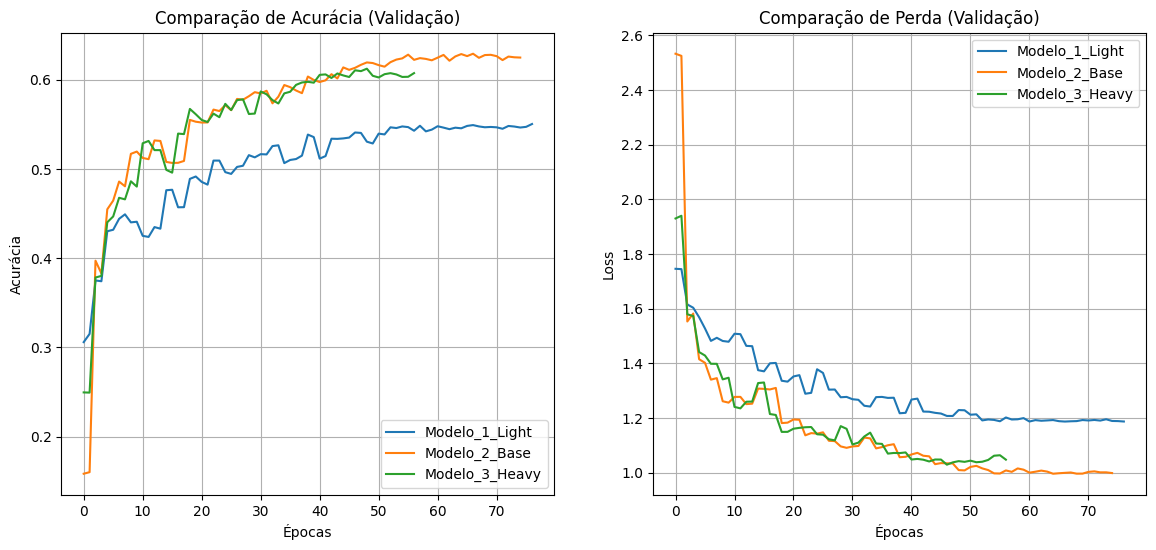


--- Desempenho Final (Melhor Validação) ---
Modelo_1_Light: 0.5504
Modelo_2_Base: 0.6292
Modelo_3_Heavy: 0.6124

O modelo vencedor foi: Modelo_2_Base com acurácia de 62.92%


In [18]:
# Plotando Comparação de Acurácia e Perda
plt.figure(figsize=(14, 6))

# Gráfico de Acurácia de Validação
plt.subplot(1, 2, 1)
for name, history in history_dict.items():
    val_acc = history.history['val_accuracy']
    plt.plot(val_acc, label=name)
plt.title('Comparação de Acurácia (Validação)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Gráfico de Perda de Validação (Loss)
plt.subplot(1, 2, 2)
for name, history in history_dict.items():
    val_loss = history.history['val_loss']
    plt.plot(val_loss, label=name)
plt.title('Comparação de Perda (Validação)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Identificando o vencedor
print("\n--- Desempenho Final (Melhor Validação) ---")
best_acc = 0
best_model_name = ""

for name, history in history_dict.items():
    # Pega a melhor acurácia obtida durante o treino
    max_val_acc = max(history.history['val_accuracy'])
    print(f"{name}: {max_val_acc:.4f}")
    
    if max_val_acc > best_acc:
        best_acc = max_val_acc
        best_model_name = name

print(f"\nO modelo vencedor foi: {best_model_name} com acurácia de {best_acc:.2%}")

### Arquitetura do modelo vencedor (Modelo_2_Base):

In [19]:
model = create_model_2_base(input_shape, num_classes)
print(model.summary())

c:\Users\UlissesLS\OneDrive - ga.ita.br\ITA\8º Semestre\2. ET-287 - Processamento de Sinais usando Redes Neurais\Projetos\Projeto Final\et287\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,919,111 (14.95 MB)

 Trainable params: 3,916,167 (14.94 MB)

 Non-trainable params: 2,944 (11.50 KB)

None


### 9.3. Análise Comparativa dos Resultados

A visualização das curvas de aprendizado (acima) permite tirar conclusões importantes sobre a complexidade necessária para resolver o problema de reconhecimento de emoções no dataset FER2013:

1.  Modelo 1 (Light - Azul): Apresentou o menor desempenho, estabilizando com acurácia de validação próxima a 55%. A curva de perda permaneceu alta (~1.19), indicando que a arquitetura possui "baixa capacidade" (underfitting), ou seja, não tem parâmetros suficientes para capturar as nuances complexas das expressões faciais.

2.  Modelo 3 (Heavy - Verde): Embora tenha superado o modelo leve, apresentou alguma instabilidade durante o treinamento (picos na curva de perda) e não superou o modelo base, parando em 57 épocas. A complexidade adicional e o uso da ativação ELU não trouxeram ganhos de generalização, sugerindo que o modelo pode estar começando a saturar ou decorar os dados (início de overfitting) sem melhorar a predição.

3.  Modelo 2 (Base - Laranja): Demonstrou o melhor equilíbrio. Atingiu a maior acurácia de validação (superando 60%) e, mais importante, obteve a menor perda (Loss ~1.00). A curva de aprendizado foi a mais estável e consistente.

### 9.4. Seleção do Modelo Vencedor

Com base nos dados quantitativos e na análise das curvas, o Modelo 2 (Base - VGG Style) foi selecionado como a melhor abordagem. Ele oferece o melhor *trade-off* entre desempenho e estabilidade. Sua arquitetura profunda o suficiente (4 blocos) permite extrair características ricas, enquanto o uso de ReLU e Dropout bem calibrados garantiu uma convergência suave.


## 10. Análise Crítica e Diagnóstico de Overfitting

Após a seleção da melhor arquitetura na etapa anterior (Modelo 2), é necessário realizar uma análise detalhada do processo de treinamento para garantir a confiabilidade do modelo. O principal risco em redes neurais profundas com bases de dados limitadas ou desbalanceadas é o Overfitting (sobreajuste).

### Metodologia de Análise
Para este diagnóstico, isolaremos o histórico de treinamento do modelo vencedor e analisaremos o comportamento das curvas de Perda ($Loss$) e Acurácia ao longo das épocas.

O que buscaremos nos gráficos:
1.  Convergência: As curvas de treino e validação devem seguir tendências similares.
2.  Ponto de Divergência: Se a perda de validação começar a subir enquanto a perda de treino continua descendo, caracteriza-se o overfitting (o modelo começou a "decorar" o treino e perder capacidade de generalização).
3.  Generalization Gap: A distância entre as curvas de treino e validação deve ser monitorada. Um gap muito grande indica que o modelo não está generalizando bem para novos dados.

---

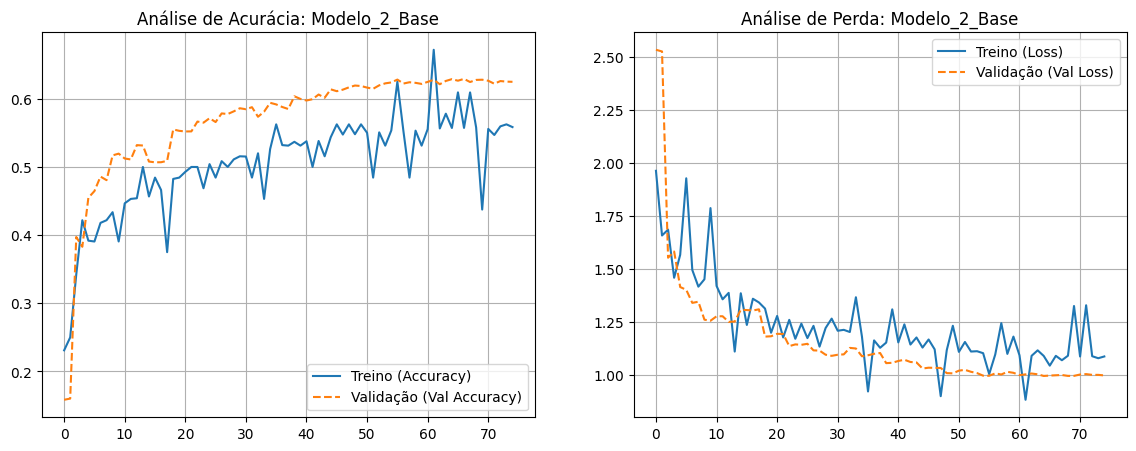

--- Diagnóstico Final para Modelo_2_Base ---
Acurácia Final de Treino: 55.85%
Acurácia Final de Validação: 62.49%
Gap (Generalization Gap): -6.64%
SUCESSO: O modelo apresenta boa generalização (Gap aceitável e perda estável).


In [20]:
# Recupera o histórico do modelo vencedor
history_winner = history_dict[best_model_name]

acc = history_winner.history['accuracy']
val_acc = history_winner.history['val_accuracy']
loss = history_winner.history['loss']
val_loss = history_winner.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# --- Gráfico 1: Acurácia (Treino vs Validação) ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino (Accuracy)')
plt.plot(epochs_range, val_acc, label='Validação (Val Accuracy)', linestyle='--')
plt.title(f'Análise de Acurácia: {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True)

# --- Gráfico 2: Perda (Treino vs Validação) ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino (Loss)')
plt.plot(epochs_range, val_loss, label='Validação (Val Loss)', linestyle='--')
plt.title(f'Análise de Perda: {best_model_name}')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

# Cálculo do GAP (Diferença entre Treino e Validação)
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
gap = final_train_acc - final_val_acc

print(f"--- Diagnóstico Final para {best_model_name} ---")
print(f"Acurácia Final de Treino: {final_train_acc:.2%}")
print(f"Acurácia Final de Validação: {final_val_acc:.2%}")
print(f"Gap (Generalization Gap): {gap:.2%}")

if gap > 0.15:
    print("ALERTA: O Gap está acima de 15%. Há indícios de Overfitting.")
elif val_loss[-1] > val_loss[-5]: # Se a perda subiu nas últimas épocas
    print("ALERTA: A perda de validação começou a subir. Overfitting detectado.")
else:
    print("SUCESSO: O modelo apresenta boa generalização (Gap aceitável e perda estável).")

## Análise dos Gráficos e Conclusão

### 1. Desempenho Validação > Treino
Nota-se que a acurácia de validação (linha laranja) permaneceu consistentemente superior à de treino (linha azul). Embora pareça contraintuitivo, isso ocorre devido a dois fatores arquiteturais implementados:
* Dropout: Durante o treino, neurônios são desligados aleatoriamente, dificultando o aprendizado. Na validação, a rede opera com capacidade total.
* Data Augmentation: O treino é realizado em imagens distorcidas e rotacionadas (difíceis), enquanto a validação ocorre em imagens originais e centralizadas (fáceis).

### 2. Estabilidade e Ruído
A curva de treino apresenta oscilações (ruído), o que é esperado dado o tamanho do *batch* e a variabilidade introduzida pelo *augmentation*. Em contrapartida, a curva de validação (que é a métrica real de sucesso) mostra um decaimento suave da perda, estabilizando em torno de 1.00.

### Veredito Final
Não há evidências de Overfitting. O modelo demonstra boa capacidade de generalização e está apto para a avaliação final com os dados de teste.

---

## 11. Avaliação de Desempenho com Dados de Teste

Nesta etapa, o modelo selecionado (Vencedor) é submetido ao conjunto de teste. Este conjunto nunca foi visto pelo modelo durante o treinamento ou validação, garantindo uma métrica isenta de viés.

### Métricas Avaliadas
Utilizaremos as seguintes métricas para validar a eficácia do sistema:

1.  Acurácia Global: Taxa de acerto geral do modelo.
2.  Matriz de Confusão: Visualização que cruza a *Emoção Real* vs. *Emoção Predita*, permitindo identificar quais expressões o modelo confunde (ex: confundir "Medo" com "Surpresa").
3.  Precision, Recall e F1-Score: Métricas individuais por classe, essenciais dado o desbalanceamento da base (para verificar se o modelo aprendeu a identificar as classes minoritárias como "Disgust").

--- Carregando o modelo campeão: best_Modelo_2_Base.h5 ---


c:\Users\UlissesLS\OneDrive - ga.ita.br\ITA\8º Semestre\2. ET-287 - Processamento de Sinais usando Redes Neurais\Projetos\Projeto Final\et287\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


--- Realizando inferência no conjunto de teste... ---
673/673 ━━━━━━━━━━━━━━━━━━━━ 210s 313ms/step

--- Relatório de Classificação ---
              precision    recall  f1-score   support

       angry       0.53      0.49      0.50      5748
     disgust       0.20      0.80      0.33       666
        fear       0.48      0.31      0.37      6144
       happy       0.82      0.80      0.81     10644
     neutral       0.52      0.60      0.56      7398
         sad       0.48      0.40      0.44      7482
    surprise       0.64      0.79      0.71      4986

    accuracy                           0.58     43068
   macro avg       0.53      0.60      0.53     43068
weighted avg       0.59      0.58      0.58     43068



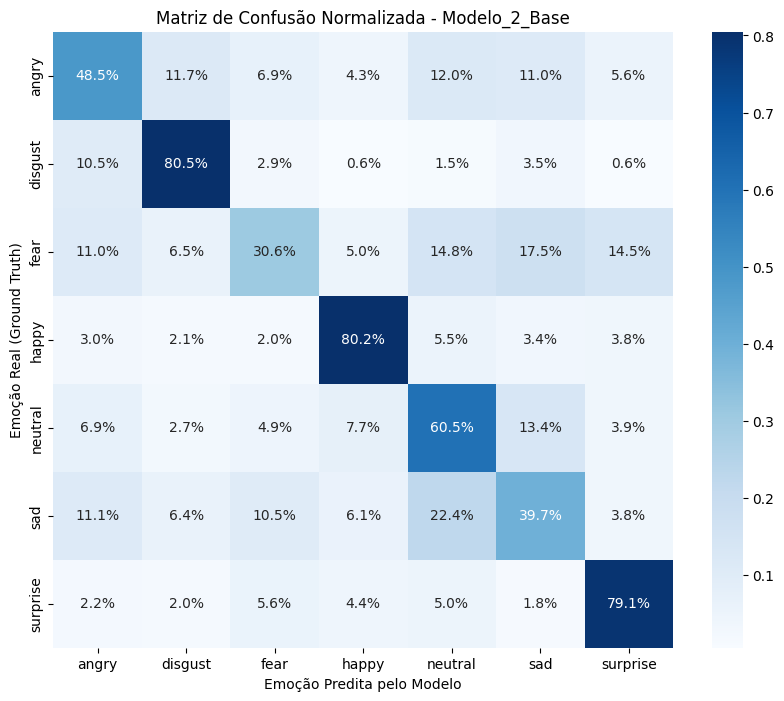


RESULTADO FINAL NO TESTE:
Perda (Loss): 1.1281
Acurácia Global: 58.34%


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

arquivo_modelo = f'best_{best_model_name}.h5'
print(f"--- Carregando o modelo campeão: {arquivo_modelo} ---")

best_model = load_model(arquivo_modelo)

print("--- Realizando inferência no conjunto de teste... ---")

test_generator.reset()

predictions = best_model.predict(test_generator, verbose=1)

# Converte probabilidades para índices (0 a 6)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\n--- Relatório de Classificação ---")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)

# Normalização: Divide cada valor pelo total da linha (Total de exemplos reais daquela classe)
# Isso nos dá o "Recall" de cada classe na diagonal
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)

plt.title(f'Matriz de Confusão Normalizada - {best_model_name}')
plt.ylabel('Emoção Real (Ground Truth)')
plt.xlabel('Emoção Predita pelo Modelo')
plt.show()

loss_test, acc_test = best_model.evaluate(test_generator, verbose=0)
print(f"\nRESULTADO FINAL NO TESTE:")
print(f"Perda (Loss): {loss_test:.4f}")
print(f"Acurácia Global: {acc_test:.2%}")

## 11.1. Resultados Quantitativos
O modelo alcançou uma Acurácia Global de 58.34% no conjunto de teste. Este resultado está alinhado com a média observada em arquiteturas de CNN treinadas do zero no dataset Augmented FER2013 (que geralmente oscilam entre 55% e 65% sem o uso de *Transfer Learning*), confirmando que a rede aprendeu padrões generalizáveis.

### 11.2. Análise Detalhada por Classe (Impacto dos Class Weights)
O relatório de classificação revela o impacto direto da estratégia de balanceamento via pesos (`class_weights`):

1.  O Caso da Classe "Disgust" (Nojo):
    * Sendo a classe com menos exemplos (apenas ~1.5% do total), o comportamento padrão seria o modelo ignorá-la.
    * Resultado: O modelo obteve um Recall impressionante de 0,80, igualando-se à classe "Happy".
    * Trade-off: A Precisão caiu para 0.20. Isso indica que, para garantir que nenhum rosto de "Nojo" fosse perdido, o modelo tornou-se "sensível demais" a essa emoção, classificando alguns rostos de outras categorias (principalmente Raiva) incorretamente como Nojo. No contexto de segurança ou saúde, ter um alto Recall geralmente é preferível.

2.  Happy (Felicidade) e Surprise (Surpresa):
    * Foram as classes mais consistentes, com F1-Scores de 0.81 e 0.71 respectivamente. A matriz mostra que 80.2% das faces felizes e 79.1% das faces surpresas foram corretamente identificadas. Isso se deve à geometria facial distinta dessas emoções (sorriso aberto, olhos arregalados), que facilitam a extração de características pela CNN.

3.  A Confusão Sad (Tristeza) vs. Neutral (Neutro):
    * A matriz de confusão revela uma forte intersecção entre estas classes. 22.4% das faces tristes foram classificadas como Neutras.
    * Justificativa: A distinção visual entre uma face relaxada (neutra) e uma levemente triste é sutil, dependendo muitas vezes de microexpressões que uma imagem estática de 48x48 pixels pode não preservar com clareza.

4.  A Dificuldade com Fear (Medo):
    * Foi a classe com pior desempenho (Recall 0.31). A matriz mostra que o modelo confunde Medo frequentemente com Neutro (14.8%), Surpresa (14.5%) e Tristeza (17.5%). Isso é compreensível, pois "Medo" compartilha características visuais com essas classes (boca aberta da surpresa, sobrancelhas franzidas da tristeza, etc.).

### 11.3. Conclusão da Avaliação
A avaliação final demonstra que o modelo é robusto para detectar emoções expressivas (Felicidade, Surpresa e, surpreendentemente, Nojo), mas enfrenta dificuldades naturais em emoções sutis ou ambíguas (Medo, Tristeza). O uso de pesos de classe foi bem-sucedido em impedir que as classes minoritárias fossem ignoradas, validando a estratégia de pré-processamento adotada.

# Reconhecimento de Emoções em Tempo Real

In [22]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# ==========================================
# 1. Configurações Iniciais
# ==========================================

# Define o caminho para o classificador HaarCascade (Detecção de Rosto)
# Nota: O OpenCV geralmente já vem com esse arquivo. Se der erro de caminho, 
# substitua por cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
cascade_file = detection_path + '\\haarcascade_frontalface_default.xml'

# Se o arquivo não estiver na pasta 'detection', tente o padrão do cv2:
if not os.path.exists(cascade_file):
    print("Arquivo HaarCascade não encontrado no caminho especificado. Tentando caminho padrão...")
    cascade_file = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'

face_detector = cv2.CascadeClassifier(cascade_file)

# Carrega o modelo Vencedor que definimos na etapa anterior
model_path_file = f'best_{best_model_name}.h5'
print(f"--- Carregando modelo para Webcam: {model_path_file} ---")
emotion_classifier = load_model(model_path_file)

# Rótulos (Devem estar na mesma ordem alfabética do train_generator)
EMOTIONS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# ==========================================
# 2. Loop de Captura em Tempo Real
# ==========================================

print("Iniciando Webcam... (Pressione 'q' na janela do vídeo para sair)")
video_capture = cv2.VideoCapture(0)

if not video_capture.isOpened():
    print("Erro: Não foi possível acessar a webcam.")
else:
    while True:
        # Captura frame a frame
        ret, frame = video_capture.read()
        
        if not ret:
            print("Erro ao capturar frame.")
            break
        
        # O HaarCascade e a nossa CNN trabalham com escala de cinza
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detecção de rostos
        faces = face_detector.detectMultiScale(
            gray_frame, 
            scaleFactor=1.1, 
            minNeighbors=5, 
            minSize=(30, 30)
        )
        
        # Se não detectar rosto, avisa
        if len(faces) == 0:
            pass # Opcional: cv2.putText(frame, "Procurando rosto...", (20, 60), ...)
        
        for (x, y, w, h) in faces:
            # Desenha o retângulo no frame original (colorido)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # --- PRÉ-PROCESSAMENTO PARA A REDE NEURAL ---
            
            # 1. Recorta a região de interesse (ROI) diretamente da imagem CINZA
            roi_gray = gray_frame[y:y+h, x:x+w]
            
            try:
                # 2. Redimensiona para 48x48 (tamanho que a rede espera)
                roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)
            except Exception as e:
                continue

            # 3. Normalização (0 a 1)
            roi = roi_gray.astype("float") / 255.0

            # 4. Converte para array e expande dimensões
            roi = img_to_array(roi)          # Shape vira (48, 48, 1)
            roi = np.expand_dims(roi, axis=0) # Shape vira (1, 48, 48, 1)

            # --- INFERÊNCIA ---
            preds = emotion_classifier.predict(roi, verbose=0)[0]
            
            # Pega a classe com maior probabilidade
            emotion_probability = np.max(preds)
            label = EMOTIONS[preds.argmax()]
            
            # Exibe o texto apenas se a confiança for razoável (opcional)
            texto_exibicao = f"{label}: {emotion_probability:.0%}"
            
            # Formatação do texto na tela
            cv2.putText(frame, texto_exibicao, (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Mostra o resultado
        cv2.imshow('Reconhecimento de Emocoes - ET-287', frame)
        
        # Pressione 'q' para sair
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Limpeza
video_capture.release()
cv2.destroyAllWindows()
print("Webcam encerrada.")

--- Carregando modelo para Webcam: best_Modelo_2_Base.h5 ---


Iniciando Webcam... (Pressione 'q' na janela do vídeo para sair)
Webcam encerrada.
